In [1]:
train_data_path = f'../data/JA_Dataset_240229.csv'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm # version 0.8.0以上

In [3]:
df = pd.read_csv(train_data_path)

In [4]:
df

,date,Week Start,Week End,Week Number,Shipment,Week Shipment,Teisyoku,Week Teisyoku,Temp,Week Temp,...,WNDDIR,Week WNDDIR,WNDSPD,Week WNDSPD,RHUM,Week RHUM,Rain,Week Rain,Status,Week Status
0,2017/12/31 0:00,2017/12/31 0:00,2018/1/6 0:00,23,2131.999998,7277.999998,0,0,6.4,34.6,...,NaN,NaN,NaN,NaN,NaN,NaN,0.5,0.5,1,3
1,2018/1/1 0:00,2017/12/31 0:00,2018/1/6 0:00,23,0.000000,7277.999998,0,0,6.8,34.6,...,161.085106,1147.126773,0.627660,6.92141,74.872340,384.434840,0.0,0.5,0,3
2,2018/1/2 0:00,2017/12/31 0:00,2018/1/6 0:00,23,0.000000,7277.999998,0,0,5.4,34.6,...,254.437500,1147.126773,1.552083,6.92141,63.583333,384.434840,0.0,0.5,0,3
3,2018/1/3 0:00,2017/12/31 0:00,2018/1/6 0:00,23,0.000000,7277.999998,0,0,6.3,34.6,...,197.770833,1147.126773,2.422917,6.92141,40.604167,384.434840,0.0,0.5,0,3
4,2018/1/4 0:00,2017/12/31 0:00,2018/1/6 0:00,23,2656.000000,7277.999998,0,0,2.9,34.6,...,159.333333,1147.126773,0.727083,6.92141,56.270833,384.434840,0.0,0.5,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2151,2023/11/21 0:00,2023/11/19 0:00,2023/11/25 0:00,17,1055.000000,6745.000000,0,0,11.8,96.3,...,195.562500,1464.000000,0.791667,12.82500,77.875000,480.979167,0.0,1.0,1,5
2152,2023/11/22 0:00,2023/11/19 0:00,2023/11/25 0:00,17,0.000000,6745.000000,0,0,14.5,96.3,...,200.458333,1464.000000,1.185417,12.82500,81.604167,480.979167,0.0,1.0,0,5
2153,2023/11/23 0:00,2023/11/19 0:00,2023/11/25 0:00,17,1967.000000,6745.000000,0,0,16.5,96.3,...,231.895833,1464.000000,1.900000,12.82500,78.166667,480.979167,1.0,1.0,1,5
2154,2023/11/24 0:00,2023/11/19 0:00,2023/11/25 0:00,17,1682.000000,6745.000000,0,0,17.8,96.3,...,237.250000,1464.000000,5.079167,12.82500,54.625000,480.979167,0.0,1.0,1,5


<Axes: xlabel='date'>

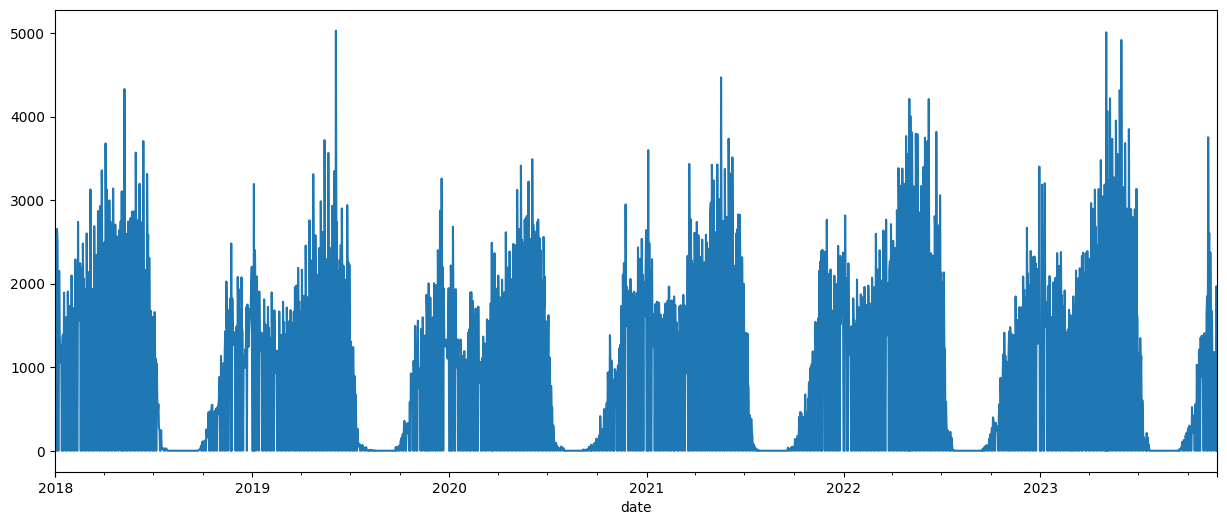

In [5]:
# Pandas.Seriesにデータを格納（データに乗客数、インデックスは日付）
key = "day"
if key == "week":
    shipment = pd.Series(df['Week Shipment'], dtype='float') # ①
elif key == "day":
    shipment = pd.Series(df['Shipment'], dtype='float') # ①
    
shipment.index = pd.to_datetime(df['date']) # ②

plt.figure(figsize=(15, 6))
shipment.plot()

<Axes: xlabel='date'>

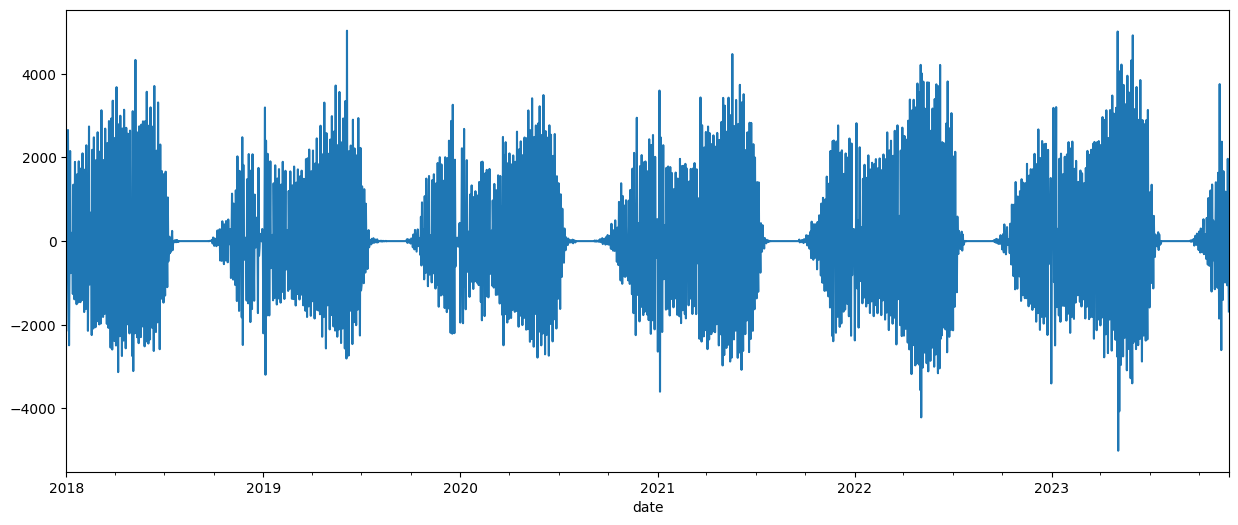

In [6]:
#一日後との差分をとるコード
N = 1
shipment_diff = shipment - shipment.shift(N) # 差分(1階差)　Pandasのdiff()でpassengers.diff()としてもOK
shipment_diff = shipment_diff.dropna() # 1個できるNaNデータは捨てる
plt.figure(figsize=(15, 6))
shipment_diff.plot()

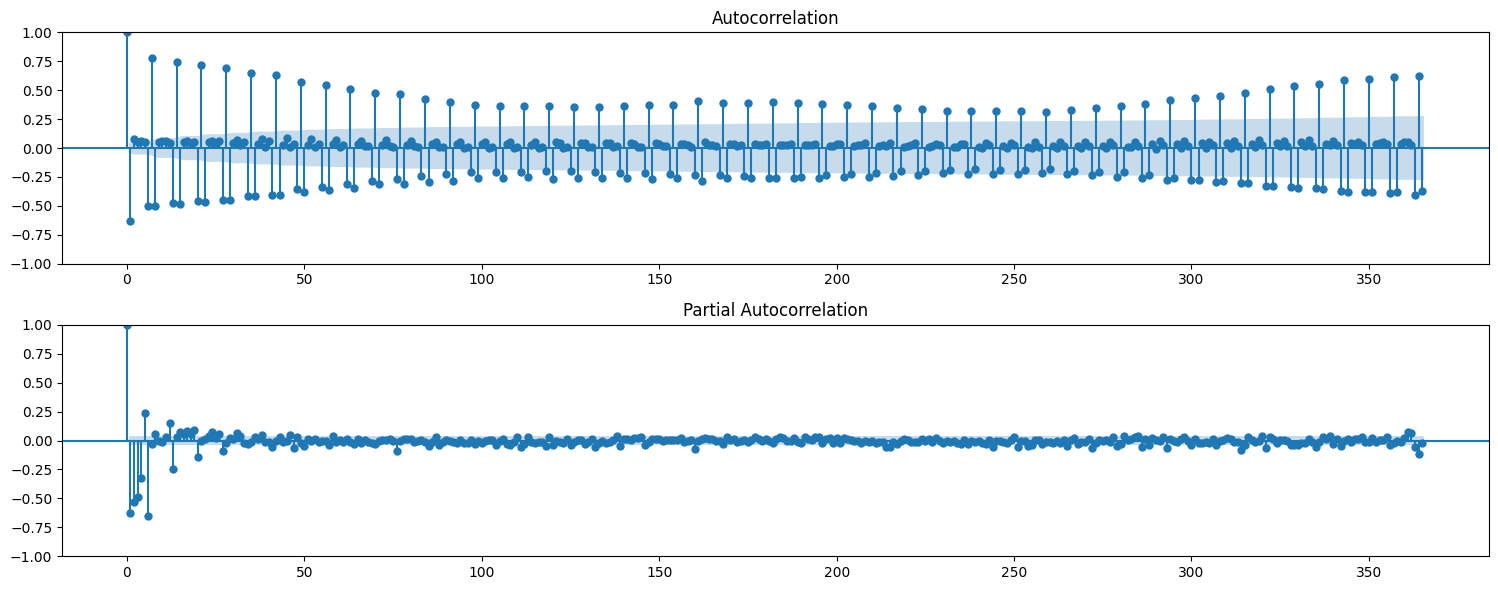

In [7]:
# 差分系列のコレログラム
fig = plt.figure(figsize=(15, 6))

# 自己相関(ACF)のグラフ
ax1 = fig.add_subplot(211)

if key == "week":
    lag_value = 53 
elif key == "day":
    lag_value = 365
sm.graphics.tsa.plot_acf(shipment_diff, lags=lag_value, ax=ax1) #ACF計算とグラフ自動作成

# 偏自己相関(PACF)のグラフ
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(shipment_diff, lags=lag_value, ax=ax2) #PACF計算とグラフ自動作成

plt.tight_layout() # グラフ間スキマ調整

In [8]:
#ARIMAモデルで必要なパラメータ推定
import warnings
warnings.filterwarnings('ignore') # 計算警告を非表示

# 自動ARMAパラメータ推定関数
res_selection = sm.tsa.arma_order_select_ic(shipment_diff, ic='aic', trend='c')
res_selection

{'aic':               0             1             2
 0  37410.510406  35415.583514  34731.478925
 1  36319.614383  35014.782827  34733.364561
 2  35589.317347  34775.726547  34720.213016
 3  34988.120121  34700.452250  34701.084333
 4  34740.150049  34697.768978  34706.811697,
 'aic_min_order': (4, 1)}

SARIMAXの引数
endog: 依存変数、またはモデル化したい時系列データ。
order: 通常のARIMAモデルのパラメータ (p, d, q)。
p: 自己回帰項の次数（AR）。
d: 差分の次数（I）。
q: 移動平均項の次数（MA）。
seasonal_order: 季節性成分のパラメータ (P, D, Q, s)。
P: 季節性自己回帰の次数。
D: 季節性差分の次数。
Q: 季節性移動平均の次数。
s: 季節の周期（例：年次データであれば12（月）、四半期データであれば4）。
enforce_stationarity: 定常性を強制するかどうか。
enforce_invertibility: 可逆性を強制するかどうか。

In [12]:
import statsmodels.api as sm

# SRIMAモデル作成
sarimax = sm.tsa.SARIMAX(shipment,
                               order=(4, 1, 1),  # ここは`arma_order_select_ic`から得られた値と差分の次数を使用
                               seasonal_order=(1, 1, 1, 12),  # 季節成分は仮定に基づいて設定
                               enforce_stationarity=False,
                               enforce_invertibility=False).fit()


In [13]:
sarimax_resid = sarimax.resid # モデルの残差成分

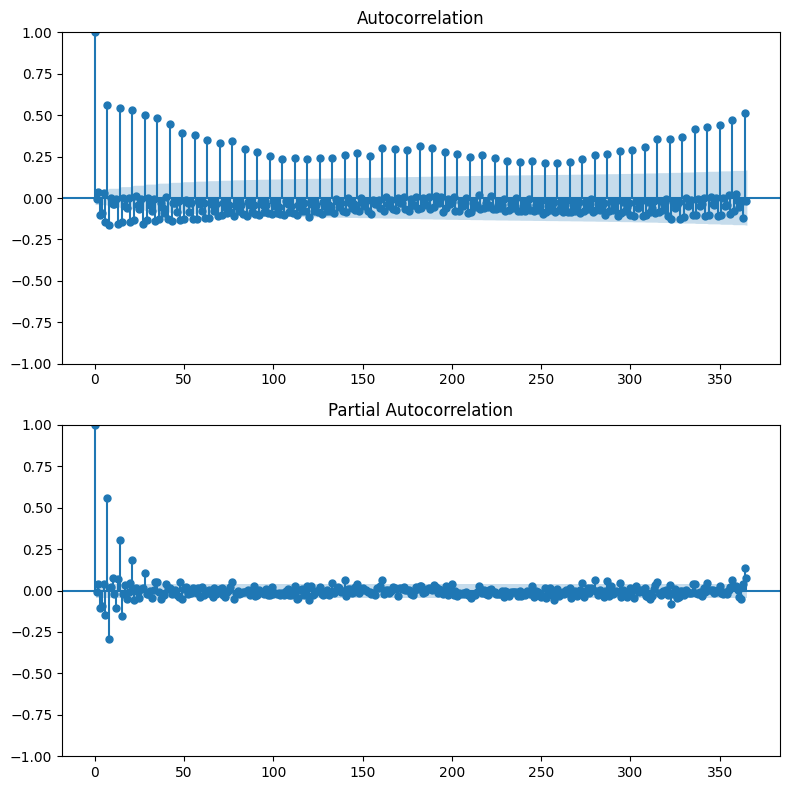

In [14]:
# モデル残差のコレログラム
fig = plt.figure(figsize=(8, 8))

# 自己相関(ACF)のグラフ
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_resid, lags=lag_value, ax=ax1) #ACF計算とグラフ自動作成

# 偏自己相関(PACF)のグラフ
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_resid, lags=lag_value, ax=ax2) #PACF計算とグラフ自動作成

plt.tight_layout() # グラフ間スキマ調整